# 합성곱 신경망(Convolutional Networks)

지금까지 우리는 깊은 완전연결 신경망(deep fully-connected networks)을 사용하여,
다양한 최적화 전략과 네트워크 구조를 탐구해 왔습니다.
완전연결 신경망은 계산 효율이 매우 높기 때문에 실험에 좋은 시험대(testbed)가 됩니다.
그러나 실제로 최신(state-of-the-art) 결과를 내는 모델들은 모두 합성곱 신경망(convolutional networks) 을 사용합니다.

이제 여러분은 합성곱 신경망에서 사용되는 여러 층(layer) 유형을 직접 구현하게 됩니다.
그 후, 이 층들을 이용하여 CIFAR-10 데이터셋에 대해 합성곱 신경망을 학습시킬 것입니다.

In [2]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
!bash utils/datasets/get_datasets.sh

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


--2025-11-02 20:47:45--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  133K 20m48s
    50K .......... .......... .......... .......... ..........  0%  265K 15m38s
   100K .......... .......... .......... .......... ..........  0% 13.0M 10m29s
   150K .......... .......... .......... .......... ..........  0% 10.7M 7m55s
   200K .......... .......... .......... .......... ..........  0%  260K 8m28s
   250K .......... .......... .......... .......... ..........  0% 5.15M 7m9s
   300K .......... .......... .......... .......... ..........  0% 5.36M 6m12s
   350K .......... .......... .......... .......... ..........  0% 5.58M 5m29s
   40

In [3]:
!pip install scikit-image
!pip install "numpy<2.0"
!pip install future

In [4]:
#mv cifar-10-batches-py ./utils/datasets/


In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# 합성곱: Naive forward pass

합성곱 신경망의 핵심은 합성곱(convolution) 연산입니다.
utils/layers.py 파일의 conv_forward_naive 함수 안에
합성곱 계층의 순전파(forward pass) 를 구현하세요.

이 단계에서는 효율성(efficiency)에 대해 너무 신경 쓸 필요는 없습니다.
가장 명확하고 이해하기 쉬운 방식으로 코드를 작성하면 됩니다.

아래의 코드를 실행하여 여러분의 구현을 테스트할 수 있습니다.

### Assignment 1: Convolution Forward Pass 구현
- 아래의 수식을 통해 outH와 outW를 계산하시오.
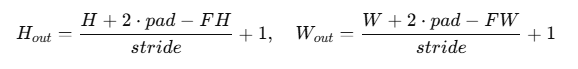
- 모든 input data에 padding을 넣으시오.
- 합성 곱 계산을 확인하시오.

In [ ]:
def conv_forward_naive(x, w, b, conv_param):
    out = None
    pad = conv_param['pad']
    stride = conv_param['stride']
    N, C, H, W = x.shape # input data shape (batch_size, channel, hight, width)
    F, C, FH, FW = w.shape # filter shape (filter_num, channel, filter_height, filter_width)

    ###########################################################################
    # Assignment 1 : Implement the convolutional forward pass.                         
    ###########################################################################
    assert (H - FH + 2 * pad) % stride == 0
    assert (W - FW + 2 * pad) % stride == 0
    outH = int(((H - FH + 2 * pad) // stride) + 1) # output hight 크기 계산
    outW = int(((W - FH + 2 * pad) // stride) + 1) # output width 크기 계산

    # create output tensor after convolution layer
    out = np.zeros((N, F, outH, outW))

    # 모든 input data에 padding을 넣으시오.
    # Hint: you can use the function np.pad for padding.                      
    x_pad = np.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad)), mode = "constant")
    H_pad, W_pad = x_pad.shape[2], x_pad.shape[3]    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    # create w_row matrix
    w_row = w.reshape(F, C*FH*FW)                            #[F x C*FH*FW]

    # create x_col matrix with values that each neuron is connected to
    x_col = np.zeros((C*FH*FW, outH*outW))                #[C*FH*FW x H'*W']
    for index in range(N):
        neuron = 0 
        for i in range(0, H_pad-FH+1, stride):
            for j in range(0, W_pad-FW+1,stride):
                x_col[:,neuron] = x_pad[index,:,i:i+FH,j:j+FW].reshape(C*FH*FW)
                neuron += 1
        out[index] = (w_row.dot(x_col) + b.reshape(F,1)).reshape(F, outH, outW)
    cache = (x_pad, w, b, conv_param)
    return out, cache

In [5]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476575931688e-08


# 참고: 합성곱을 이용한 이미지 처리

구현을 확인하고 동시에 합성곱 계층이 수행할 수 있는 연산의 종류를 더 잘 이해하기 위한 재미있는 방법으로,
두 장의 이미지를 포함하는 입력을 설정하고,
흑백 변환(grayscale conversion)과 에지 감지(edge detection) 와 같은
일반적인 이미지 처리 연산을 수행하는 필터를 수동으로 설정할 것입니다.

합성곱의 순전파(forward pass)는 이러한 연산들을 각 입력 이미지에 적용할 것입니다.
그 후 결과를 시각화하여 올바르게 동작하는지 확인할 수 있습니다.

### 🧠 Assignment2: 합성곱 순전파 (Convolution Forward Pass)

이제 여러분이 구현한 conv_forward_naive() 함수를 실제 이미지에 적용해 봅시다.
두 장의 입력 이미지(puppy, kitten)에 대해
두 개의 필터(하나는 흑백 변환, 하나는 에지 감지)를 사용하여 합성곱 연산을 수행합니다.
아래의 out, _ = conv_forward_naive()를 채우고 결과를 확인하세요.

C:\Users\smg92\AppData\Local\Temp\ipykernel_18804\1656933400.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')


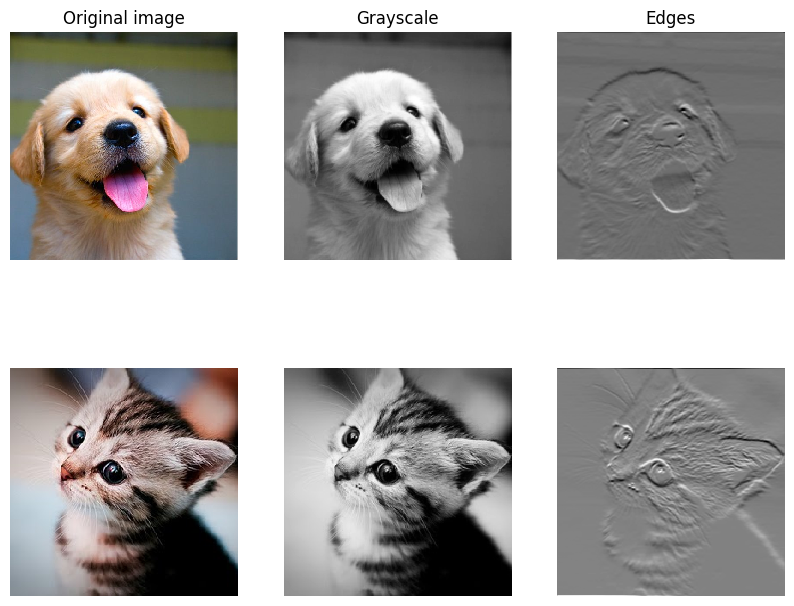

In [6]:
from imageio import imread
from skimage.transform import resize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = (resize(puppy, (img_size, img_size), anti_aliasing=True) * 255).transpose((2, 0, 1))
x[1, :, :, :] = (resize(kitten_cropped, (img_size, img_size), anti_aliasing=True) * 255).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

##############################################################################
# Assignment: Perform the convolution                                        #
# Use your conv_forward_naive() implementation with stride=1, pad=1          #
##############################################################################
conv_param = {'stride': 1, 'pad': 1}
out, _ = conv_forward_naive(x,w,b,conv_param)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# 합성곱: Naive backward pass

아래의 conv_backward_naive 함수 안에서
합성곱 연산의 역전파(backward pass)를 확인하시오.

확인이 완료되면, 아래의 코드를 실행하여 수치적 그래디언트 검증(numeric gradient check) 을 통해
당신의 역전파 구현이 올바른지 확인하시오.

In [7]:
def conv_backward_naive(dout, cache):
    dx, dw, db = None, None, None
    x_pad, w, b, conv_param = cache
    N, F, outH, outW = dout.shape
    N, C, Hpad, Wpad = x_pad.shape
    FH, FW = w.shape[2], w.shape[3]
    stride = conv_param['stride']
    pad = conv_param['pad']

    # initialize gradients
    dx = np.zeros((N, C, Hpad - 2*pad, Wpad - 2*pad))
    dw, db = np.zeros(w.shape), np.zeros(b.shape)

    # create w_row matrix
    w_row = w.reshape(F, C*FH*FW)                            #[F x C*FH*FW]

    # create x_col matrix with values that each neuron is connected to
    x_col = np.zeros((C*FH*FW, outH*outW))                   #[C*FH*FW x H'*W']
    for index in range(N):
        out_col = dout[index].reshape(F, outH*outW)          #[F x H'*W']
        w_out = w_row.T.dot(out_col)                         #[C*FH*FW x H'*W']
        dx_cur = np.zeros((C, Hpad, Wpad))
        neuron = 0
        for i in range(0, Hpad-FH+1, stride):
            for j in range(0, Wpad-FW+1, stride):
                dx_cur[:,i:i+FH,j:j+FW] += w_out[:,neuron].reshape(C,FH,FW)
                x_col[:,neuron] = x_pad[index,:,i:i+FH,j:j+FW].reshape(C*FH*FW)
                neuron += 1
        dx[index] = dx_cur[:,pad:-pad, pad:-pad]
        dw += out_col.dot(x_col.T).reshape(F,C,FH,FW)
        db += out_col.sum(axis=1)
    return dx, dw, db

In [8]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  7.99015495883212e-09
dw error:  2.678282757595412e-10
db error:  3.8835192329918934e-11


# 최대 풀링(Max-Pooling): 단순 순전파 (Naive forward)
### 🧠 Assignment3: Naive forward 구현
아래의 max_pool_forward_naive 함수 안에서
최대 풀링 연산(max-pooling operation) 의 순전파(forward pass)를 구현하시오.

계산 효율성에 대해서는 너무 걱정할 필요가 없습니다.

구현이 완료되면, 아래의 코드를 실행하여
당신의 순전파 구현이 올바른지 확인하시오.

In [9]:
def max_pool_forward_naive(x, pool_param):
    out = None
    N, C, H, W = x.shape
    stride = pool_param['stride']
    PH = pool_param['pool_height']
    PW = pool_param['pool_width']
    outH = int(1 + (H - PH) / stride)
    outW = int(1 + (W - PW) / stride)

    # create output tensor for pooling layer
    out = np.zeros((N, C, outH, outW))
    for index in range(N):
        out_col = np.zeros((C, outH*outW))
        neuron = 0
    ###########################################################################
    # TODO: Implement the max-pooling forward pass                            #
    ###########################################################################
        for i in range(0, H - PH + 1, stride):
            for j in range(0, W - PW + 1, stride):
                pool_region = x[index, :, i:i+PH, j:j+PW].reshape(C, PH*PW)
                out_col[:,neuron] = pool_region.max(axis=1)
                neuron += 1
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
        out[index] = out_col.reshape(C, outH, outW)
    cache = (x, pool_param)
    return out, cache

In [10]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# 최대 풀링(Max-Pooling): 단순 역전파 (Naive backward)
### 🧠 Assignment4: Max-Pooling Navie backward 구현
아래의 max_pool_backward_naive 함수 안에서
최대 풀링 연산(max-pooling operation) 의 역전파(backward pass) 를 구현하시오.

계산 효율성에 대해서는 신경 쓸 필요가 없습니다.

구현이 완료되면, 아래의 코드를 실행하여
수치적 그래디언트 검증(numeric gradient checking) 을 통해
당신의 역전파 구현이 올바른지 확인하시오.

In [11]:
def max_pool_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a max-pooling layer.

    Inputs:
    - dout: Upstream derivatives
    - cache: A tuple of (x, pool_param) as in the forward pass.

    Returns:
    - dx: Gradient with respect to x
    """
    dx = None
    x, pool_param = cache
    N, C, outH, outW = dout.shape
    H, W = x.shape[2], x.shape[3]
    stride = pool_param['stride']
    PH, PW = pool_param['pool_height'], pool_param['pool_width']

    # initialize gradient
    dx = np.zeros(x.shape)
    
    for index in range(N):
        dout_row = dout[index].reshape(C, outH*outW)
        neuron = 0
        for i in range(0, H-PH+1, stride):
            for j in range(0, W-PW+1, stride):
    ###########################################################################
    # TODO: Implement the max-pooling backward pass                           #
    ###########################################################################
                pool_region = x[index,:,i:i+PH, j:j+PW].reshape(C, PH*PW)
                max_pool_indices = pool_region.argmax(axis=1)
                dout_cur = dout_row[:, neuron]
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
                neuron += 1
                # pass gradient only through indices of max pool
                dmax_pool = np.zeros(pool_region.shape)
                dmax_pool[np.arange(C),max_pool_indices] = dout_cur
                dx[index,:,i:i+PH,j:j+PW] += dmax_pool.reshape(C,PH,PW)
    return dx

In [12]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


In [13]:
import sys, platform
print("exe:", sys.executable)
print("version:", sys.version)
print("platform:", platform.platform())


exe: c:\Users\smg92\miniconda3\envs\ssu_knn\python.exe
version: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
platform: Windows-10-10.0.26100-SP0


# Convolutional "sandwich" layers

수업에서 우리는 여러 연산을 결합하여 자주 사용되는 패턴을 형성하는
“샌드위치(sandwich)” 계층의 개념을 소개했습니다.

utils/layer_utils.py 파일에는 합성곱 신경망에서 자주 사용되는 몇 가지 패턴을 구현한
샌드위치 계층들이 포함되어 있습니다.

In [23]:
from utils.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  9.591132621921372e-09
dw error:  5.802401370096438e-09
db error:  1.0146343411762047e-09


In [25]:
from utils.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.5218619980349303e-09
dw error:  2.702022646099404e-10
db error:  1.451272393591721e-10


# 3층 합성곱 신경망 (Three-layer ConvNet)

이제 필요한 모든 계층들을 구현했으므로,
이들을 결합하여 하나의 간단한 합성곱 신경망을 구성할 수 있습니다.

## Assignment 5: ThreeLayerConvNet 클래스 구현.
아래의 ThreeLayerConvNet 클래스를 완성합니다.

구현할 때, 이미 불러와져 있는 fast 계층과 sandwich 계층을 사용할 수 있음을 기억하세요.

아래의 셀들을 실행하여 구현을 디버그할 수 있습니다.

In [29]:
from builtins import object
import numpy as np

def affine_relu_forward(x, w, b):
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

def conv_relu_forward(x, w, b, conv_param):
    a, conv_cache = conv_forward_fast(x, w, b, conv_param)
    out, relu_cache = relu_forward(a)
    cache = (conv_cache, relu_cache)
    return out, cache

def affine_forward(x, w, b):
    out = None
    dim_size = x[0].shape
    X = x.reshape(x.shape[0], np.prod(dim_size))
    out = X.dot(w) + b
    cache = (x, w, b)
    return out, cache

def softmax_loss(x, y):
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx
    
def relu_forward(x):
    out = None
    out = np.maximum(0, x)
    cache = x
    return out, cache

def relu_backward(dout, cache):
    dx, x = None, cache
    dx = dout * (x > 0)
    return dx

def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db
  

def affine_backward(dout, cache):
    x, w, b = cache
    dx, dw, db = None, None, None
    dim_shape = np.prod(x[0].shape)
    N = x.shape[0]
    X = x.reshape(N, dim_shape)
    # input gradient
    dx = dout.dot(w.T)
    dx = dx.reshape(x.shape)
    # weight gradient
    dw = X.T.dot(dout)
    # bias gradient
    db = dout.sum(axis=0)
    return dx, dw, db

def conv_relu_pool_backward(dout, cache):
    """
    Backward pass for the conv-relu-pool convenience layer
    """
    conv_cache, relu_cache, pool_cache = cache
    ds = max_pool_backward_fast(dout, pool_cache)
    da = relu_backward(ds, relu_cache)
    dx, dw, db = conv_backward_fast(da, conv_cache)
    return dx, dw, db
    
class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:

    conv - relu - 2x2 max pool - affine - relu - affine - softmax

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
                 hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
                 dtype=np.float32):
        self.params = {}
        self.reg = reg
        self.dtype = dtype
        self.grads = None
        C, H, W = input_dim
        HP, WP = 1 + (H - 2)//2, 1 + (W - 2)//2  # max pooling
        self.params['W1'] = weight_scale * np.random.randn(num_filters, C, filter_size, filter_size)
        self.params['b1'] = np.zeros(num_filters)
        self.params['W2'] = weight_scale * np.random.randn(num_filters*HP*WP, hidden_dim)
        self.params['b2'] = np.zeros(hidden_dim)
        self.params['W3'] = weight_scale * np.random.randn(hidden_dim, num_classes)
        self.params['b3'] = np.zeros(num_classes)

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        # Initialize gradient dictionary
        grads = {}
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        # pass conv_param to the forward pass for the convolutional layer
        # Padding and stride chosen to preserve the input spatial size
        filter_size = W1.shape[2]
        conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the three-layer convolutional net,  #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #
        #                                                                          #
        # Remember you can use the functions defined in cs231n/fast_layers.py and  #
        # cs231n/layer_utils.py in your implementation (already imported).         #
        ############################################################################
        pool_out, cache = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param)
        X2, fc_cache = affine_relu_forward(pool_out, W2, b2)
        scores, fc2_cache = affine_forward(X2, W3, b3)

        if y is None:
            return scores

        loss, grads = 0, {}
        loss, softmax_grad = softmax_loss(scores, y)
        loss += 0.5 * self.reg * np.sum(W1 * W1)
        loss += 0.5 * self.reg * np.sum(W2 * W2)
        loss += 0.5 * self.reg * np.sum(W3 * W3)
        
        # backpropagation of gradients
        dout, grads['W3'], grads['b3'] = affine_backward(softmax_grad, fc2_cache)
        dout, grads['W2'], grads['b2'] = affine_relu_backward(dout, fc_cache)
        dout, grads['W1'], grads['b1'] = conv_relu_pool_backward(dout, cache)
        
        # L2 regularization
        grads['W1'] += self.reg * W1
        grads['W2'] += self.reg * W2
        grads['W3'] += self.reg * W3

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return loss, grads


# 손실에 대한 정상 작동 확인 (Sanity check loss)

새로운 네트워크를 구축한 후,
가장 먼저 해야 할 일 중 하나는 손실(loss) 이 정상적으로 계산되는지 확인하는 것입니다.

softmax loss를 사용할 때,
무작위 가중치(random weights)를 사용하고 정규화(regularization) 를 적용하지 않으면,
손실 값은 대략적으로 log(C)가 되어야 합니다.
여기서 C는 클래스(class)의 개수입니다.

정규화를 추가하면 손실 값은 이보다 더 커져야 합니다.

In [30]:
from utils.fast_layers import max_pool_backward_fast, conv_backward_fast
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302585412176879
Initial loss (with regularization):  2.508542484760139


## 그래디언트(Gradient) 확인

손실(loss)이 합리적인 값을 보인다면,
수치적 그래디언트 검증(numeric gradient checking) 을 사용하여
역전파(backward pass)가 올바르게 구현되었는지 확인해야 합니다.

수치적 그래디언트 검증을 수행할 때는
소량의 인공 데이터(artificial data)와
각 계층(layer)마다 적은 수의 뉴런(neuron)을 사용하는 것이 좋습니다.

참고: 구현이 정확하더라도,
상대 오차(relative error)가 최대 약 1e-2 정도까지 발생할 수 있습니다.

In [31]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


## 작은 데이터셋에 과적합시키기 (Overfit small data)

유용한 한 가지 방법은 아주 적은 양의 학습 샘플로 모델을 학습시키는 것입니다.
이 경우 모델은 작은 데이터셋에 과적합(overfit) 하게 되며,
그 결과 훈련 정확도(training accuracy) 는 매우 높아지고
검증 정확도(validation accuracy) 는 상대적으로 낮게 나타나게 됩니다.

In [32]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 2.414060
(Epoch 0 / 15) train acc: 0.200000; val_acc: 0.137000
(Iteration 2 / 30) loss: 3.102925
(Epoch 1 / 15) train acc: 0.140000; val_acc: 0.087000
(Iteration 3 / 30) loss: 2.270330
(Iteration 4 / 30) loss: 2.096705
(Epoch 2 / 15) train acc: 0.240000; val_acc: 0.094000
(Iteration 5 / 30) loss: 1.838880
(Iteration 6 / 30) loss: 1.934188
(Epoch 3 / 15) train acc: 0.510000; val_acc: 0.173000
(Iteration 7 / 30) loss: 1.827912
(Iteration 8 / 30) loss: 1.639574
(Epoch 4 / 15) train acc: 0.520000; val_acc: 0.188000
(Iteration 9 / 30) loss: 1.330082
(Iteration 10 / 30) loss: 1.756115
(Epoch 5 / 15) train acc: 0.630000; val_acc: 0.167000
(Iteration 11 / 30) loss: 1.024162
(Iteration 12 / 30) loss: 1.041826
(Epoch 6 / 15) train acc: 0.750000; val_acc: 0.229000
(Iteration 13 / 30) loss: 1.142777
(Iteration 14 / 30) loss: 0.835706
(Epoch 7 / 15) train acc: 0.790000; val_acc: 0.247000
(Iteration 15 / 30) loss: 0.587786
(Iteration 16 / 30) loss: 0.645509
(Epoch 8 / 15) tr

손실(loss), 학습 정확도(training accuracy), 그리고 검증 정확도(validation accuracy)를 그래프로 시각화하면, 명확한 과적합(overfitting) 현상이 드러나야 합니다.

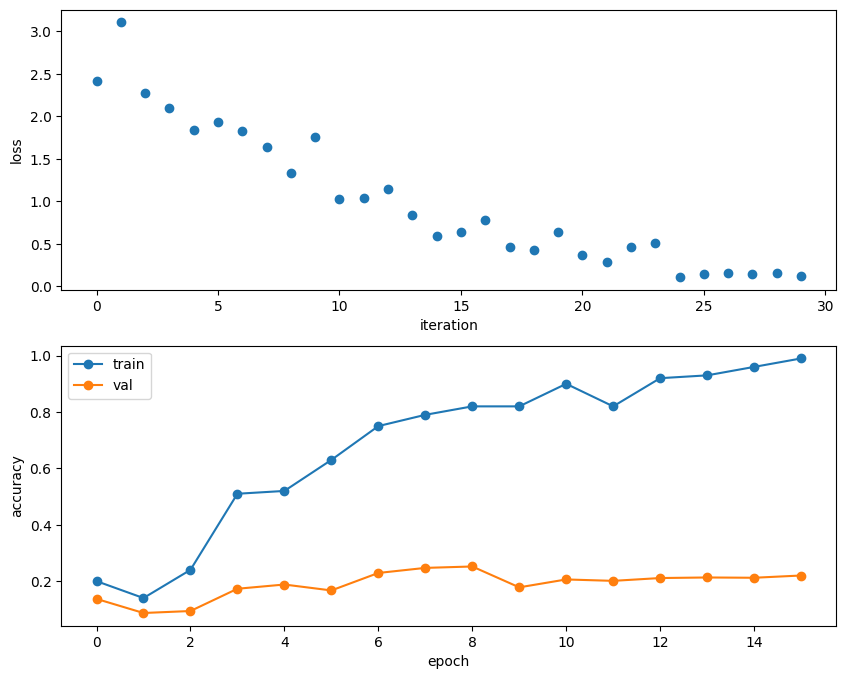

In [33]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# ThreeLayeraConvnet 을 사용하여 학습하기

3층 합성곱 신경망(Three-layer Convolutional Network)을
1 에폭(epoch) 동안 학습시키면,
훈련 데이터셋에서 40% 이상의 정확도(accuracy) 를 달성해야 합니다.

In [34]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.304740
(Epoch 0 / 1) train acc: 0.103000; val_acc: 0.107000
(Iteration 21 / 980) loss: 2.098229
(Iteration 41 / 980) loss: 1.949788
(Iteration 61 / 980) loss: 1.888398
(Iteration 81 / 980) loss: 1.877093
(Iteration 101 / 980) loss: 1.851877
(Iteration 121 / 980) loss: 1.859353
(Iteration 141 / 980) loss: 1.800181
(Iteration 161 / 980) loss: 2.143292
(Iteration 181 / 980) loss: 1.830573
(Iteration 201 / 980) loss: 2.037280
(Iteration 221 / 980) loss: 2.020304
(Iteration 241 / 980) loss: 1.823728
(Iteration 261 / 980) loss: 1.692679
(Iteration 281 / 980) loss: 1.882594
(Iteration 301 / 980) loss: 1.798261
(Iteration 321 / 980) loss: 1.851960
(Iteration 341 / 980) loss: 1.716323
(Iteration 361 / 980) loss: 1.897655
(Iteration 381 / 980) loss: 1.319744
(Iteration 401 / 980) loss: 1.738790
(Iteration 421 / 980) loss: 1.488866
(Iteration 441 / 980) loss: 1.718409
(Iteration 461 / 980) loss: 1.744440
(Iteration 481 / 980) loss: 1.605460
(Iteration 501 / 980) loss: 

# 필터 시각화 (Visualize Filters)

훈련된 네트워크의 첫 번째 합성곱 계층(convolutional layer) 에서 학습된
필터(filters) 를 시각화하려면, 다음 코드를 실행하면 됩니다.

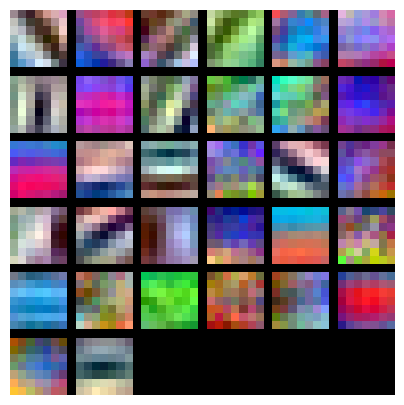

In [35]:
from utils.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization

우리는 이미 **배치 정규화(Batch Normalization)** 가 깊은 **완전연결 신경망(Fully-Connected Network)** 의 학습에 매우 유용한 기법임을 보았습니다.

원 논문 [3]에서 제안된 바와 같이,  
배치 정규화는 **합성곱 신경망(Convolutional Network)** 에도 적용할 수 있습니다.  
다만, 약간의 수정이 필요하며, 이 수정된 형태를 **공간 배치 정규화(Spatial Batch Normalization)** 라고 부릅니다.  

일반적인 배치 정규화는 입력 형태가 `(N, D)` 이며, 출력 또한 `(N, D)` 형태로 생성됩니다.  
이때 정규화는 **미니배치 차원 N** 에 대해 수행됩니다.  

반면, 합성곱 계층에서의 데이터는 입력 형태가 `(N, C, H, W)` 이고 출력도 `(N, C, H, W)` 형태여야 합니다.  
여기서 `N`은 미니배치 크기(batch size), `(H, W)`는 특성 맵(feature map)의 공간적 크기를 의미합니다.  

합성곱을 통해 생성된 특성 맵의 경우, 각 **특징 채널(feature channel)** 의 통계적 특성이 이미지 간뿐 아니라 동일 이미지 내의 위치 간에도 상대적으로 일관될 것으로 예상할 수 있습니다.

따라서 **공간 배치 정규화(spatial batch normalization)** 에서는 미니배치 차원 `N`과 공간 차원 `(H, W)` 전반에 걸쳐  
각 채널 `C`마다 평균(mean)과 분산(variance)을 계산하여 정규화를 수행합니다.  

---

**참고 문헌**  
[3] Sergey Ioffe and Christian Szegedy,  
“*Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift*”,  
ICML 2015. [논문 링크](https://arxiv.org/abs/1502.03167)


## Assignment6: 아래의 batchnorm_forward와 spatial_batchnorm_forward 함수를 구현하시오.
- 빈칸을 채우고 함수를 완성시키면 됩니다.
- 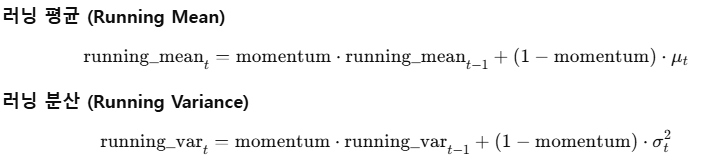

In [36]:
def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    out, cache = None, None

    N, C, H, W = x.shape
    x = x.transpose(0,2,3,1).reshape(N*H*W, C)
    out, cache = batchnorm_forward(x, gamma, beta, bn_param)
    out = out.reshape(N, H, W, C).transpose(0,3,1,2)

    return out, cache


def batchnorm_forward(x, gamma, beta, bn_param):
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)
    layernorm = bn_param.get('layernorm', 0)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        mu = x.mean(axis=0)
        var = x.var(axis=0) + eps
        std = np.sqrt(var)
        z = (x - mu)/std
        out = gamma * z + beta
        if layernorm == 0:
           # running weighted average
           running_mean = momentum * running_mean + (1 - momentum) * mu
           running_var = momentum * running_var + (1 - momentum) * x.var(axis = 0)
        # save values for backward call
        cache={'x':x,'mean':mu,'std':std,'gamma':gamma,'z':z,'var':var,'axis':layernorm}
    elif mode == 'test':
        out = gamma * (x - running_mean) / np.sqrt(running_var + eps) + beta
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

In [37]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [38]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


## 공간 배치 정규화: 역전파

아래에 정의된 역전파의 구현을 확인하시오.

수치적 그래디언트 검사(numeric gradient check) 를 사용하여
구현이 올바른지 확인하기 위해 다음 코드를 실행하시오.

In [39]:
def spatial_batchnorm_backward(dout, cache):
    dx, dgamma, dbeta = None, None, None
    N, C, H, W = dout.shape
    dout = dout.transpose(0,2,3,1).reshape(N*H*W, C)
    dx, dgamma, dbeta = batchnorm_backward_alt(dout, cache)
    dx = dx.reshape(N, H, W, C).transpose(0,3,1,2)
    return dx, dgamma, dbeta
    
def batchnorm_backward_alt(dout, cache):
    dx, dgamma, dbeta = None, None, None
    dbeta = dout.sum(axis=cache['axis'])
    dgamma = np.sum(dout * cache['z'], axis=cache['axis'])

    N = dout.shape[0]
    z = cache['z']
    dfdz = dout * cache['gamma']                                    #[NxD]
    dfdz_sum = np.sum(dfdz,axis=0)                                  #[1xD]
    dx = dfdz - dfdz_sum/N - np.sum(dfdz * z,axis=0) * z/N          #[NxD]
    dx /= cache['std']
    return dx, dgamma, dbeta

In [40]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.7866481890178303e-07
dgamma error:  7.0974817113608705e-12
dbeta error:  3.275608725278405e-12


# Group Normalization

이전 노트북에서 우리는 **Layer Normalization (층 정규화)** 이 **Batch Normalization (배치 정규화)** 의 한계를 보완하는 대안적 정규화 방법임을 언급했습니다.

즉, 배치 크기가 작거나 불규칙할 때도 안정적으로 학습할 수 있게 해줍니다.  

그러나 논문 [4]의 저자들이 지적했듯이, **합성곱 신경망 (Convolutional Neural Network, CNN)** 에서는 Layer Normalization이 Batch Normalization만큼 잘 작동하지 않습니다.

> 완전연결층(fully connected layer)에서는 한 층의 모든 은닉 유닛이 최종 예측에 비슷한 기여를 하므로 입력의 재중심화와 재스케일링이 잘 작동한다.  
> 그러나 합성곱 신경망에서는 이런 가정이 더 이상 성립하지 않는다.  
> 특히 이미지의 경계 근처에 있는 유닛들은 거의 활성화되지 않으며, 같은 층 내의 다른 유닛들과 매우 다른 통계적 특성을 가진다.

이에 논문 [5]의 저자들은 **중간적인 접근(intermediary technique)** 을 제안했습니다.  
Layer Normalization에서는 각 데이터 포인트의 전체 피처(feature)를 정규화하지만,  
**Group Normalization** 에서는 각 데이터 포인트의 피처를 일정한 수의 그룹 \(G\) 으로 나누고,  
**각 그룹 단위로 정규화(per-group per-datapoint normalization)** 를 수행합니다.

---

![Comparison of normalization techniques discussed so far](normalization.png)
<center>**지금까지 다룬 정규화 기법들의 시각적 비교 (출처: [5] 수정본)**</center>

---

각 그룹 내에서는 여전히 “모든 유닛이 비슷한 기여를 한다”는 가정을 하지만, 이는 큰 문제가 되지 않는다고 저자들은 주장합니다.  
시각 인식에서는 피처들 간에 **자연스러운 그룹 구조** 가 존재하기 때문입니다.  

예를 들어, 기존 컴퓨터 비전에서 널리 사용된 **HOG (Histogram of Oriented Gradients)** 특징에서는  
공간적으로 인접한 블록 단위로 히스토그램을 계산하고, 각 블록의 히스토그램을 **정규화(normalize)** 한 뒤 이를 연결(concatenate)하여 최종 피처 벡터를 구성합니다.
이 과정은 Group Normalization과 유사한 아이디어를 보여줍니다.

---

이제 여러분은 **Group Normalization** 을 직접 구현하게 됩니다.  

---

**참고 문헌**

[4] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. *“Layer Normalization.”* stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)  
[5] [Wu, Yuxin, and Kaiming He. *“Group Normalization.”* arXiv preprint arXiv:1803.08494 (2018).](https://arxiv.org/abs/1803.08494)  
[6] [N. Dalal and B. Triggs. *“Histograms of Oriented Gradients for Human Detection.”* In *Computer Vision and Pattern Recognition (CVPR)*, 2005.](https://ieeexplore.ieee.org/abstract/document/1467360/)


## Group normalization: forward

### Assignment7 : spatial_groupnorm_forward 구현
아래 함수`spatial_groupnorm_forward`를 구현하시오.
빈 칸에 들어갈 코드를 작성하고 함수 정의를 확인하려면 print셸을 통해 확인하시오.

In [41]:
def spatial_groupnorm_forward(x, gamma, beta, G, gn_param):
    out, cache = None, None
    eps = gn_param.get('eps',1e-5)
    N, C, H, W = x.shape
    size = (N*G, C//G *H*W)
    x = x.reshape(size).T
    gamma = gamma.reshape(1, C, 1, 1)
    beta = beta.reshape(1, C, 1, 1)
    # similar to batch normalization
    mu = x.mean(axis=0)
    var = x.var(axis=0) + eps
    std = np.sqrt(var)
    z = (x - mu)/std
    z = z.T.reshape(N, C, H, W)
    out = gamma * z + beta # 과제
    # save values for backward call
    cache={'std':std, 'gamma':gamma, 'z':z, 'size':size}
    return out, cache

In [42]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 6, 4, 5
G = 2
x = 4 * np.random.randn(N, C, H, W) + 10
x_g = x.reshape((N*G,-1))
print('Before spatial group normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x_g.mean(axis=1))
print('  Stds: ', x_g.std(axis=1))

# Means should be close to zero and stds close to one
gamma, beta = np.ones((1,C,1,1)), np.zeros((1,C,1,1))
bn_param = {'mode': 'train'}

out, _ = spatial_groupnorm_forward(x, gamma, beta, G, bn_param)
out_g = out.reshape((N*G,-1))
print('After spatial group normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out_g.mean(axis=1))
print('  Stds: ', out_g.std(axis=1))

Before spatial group normalization:
  Shape:  (2, 6, 4, 5)
  Means:  [9.72505327 8.51114185 8.9147544  9.43448077]
  Stds:  [3.67070958 3.09892597 4.27043622 3.97521327]
After spatial group normalization:
  Shape:  (2, 6, 4, 5)
  Means:  [-2.14643118e-16  5.25505565e-16  2.65528340e-16 -3.38618023e-16]
  Stds:  [0.99999963 0.99999948 0.99999973 0.99999968]


### forward를 통해 나온 값들이 `spatial_groupnorm_backward` 함수를 통해 backward까지 잘 되는지 확인하시오.

In [43]:
def spatial_groupnorm_backward(dout, cache):
    dx, dgamma, dbeta = None, None, None

    N, C, H, W = dout.shape
    size = cache['size']
    dbeta = dout.sum(axis=(0,2,3), keepdims=True)
    dgamma = np.sum(dout * cache['z'], axis=(0,2,3), keepdims=True)

    # reshape tensors
    z = cache['z'].reshape(size).T
    M = z.shape[0]
    dfdz = dout * cache['gamma']
    dfdz = dfdz.reshape(size).T
    # copy from batch normalization backward alt
    dfdz_sum = np.sum(dfdz,axis=0)
    dx = dfdz - dfdz_sum/M - np.sum(dfdz * z,axis=0) * z/M
    dx /= cache['std']
    dx = dx.T.reshape(N, C, H, W)
    return dx, dgamma, dbeta

In [44]:
np.random.seed(231)
N, C, H, W = 2, 6, 4, 5
G = 2
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(1,C,1,1)
beta = np.random.randn(1,C,1,1)
dout = np.random.randn(N, C, H, W)

gn_param = {}
fx = lambda x: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fg = lambda a: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fb = lambda b: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_groupnorm_forward(x, gamma, beta, G, gn_param)
dx, dgamma, dbeta = spatial_groupnorm_backward(dout, cache)

#You should expect errors of magnitudes between 1e-12~1e-07
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  7.413109384854475e-08
dgamma error:  9.468195772749234e-12
dbeta error:  3.354494437653335e-12
